## rioxarray
In this lesson we will introduce rioxarray, a Python extension for xarray to manipulate xarray.DataArrays as rasters. The name rioxarray stands for raster input/output + xarray. We will use the rioxarray’s rio accessor to obtain raster information from an xarray.DataArray and do some raster manipulations (calculate NDVI).

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import rioxarray as rioxr

import geopandas as gpd
from shapely.geometry import Polygon

In [2]:
nir_fp = os.path.join(os.getcwd(),'raster_data','nir.tif')
nir = rioxr.open_rasterio(nir_fp)
nir

<xarray.DataArray (band: 1, y: 3208, x: 2419)>
[7760152 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 2.512e+05 2.512e+05 ... 2.527e+05 2.527e+05
  * y            (y) float64 3.813e+06 3.813e+06 ... 3.811e+06 3.811e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [3]:
type(nir)

xarray.core.dataarray.DataArray

In [4]:
# print shape and data type
print('shape: ', nir.shape)
print('data type: ', nir.dtype, '\n')

shape:  (1, 3208, 2419)
data type:  uint8 



In [5]:
print(type(nir.values))
nir.values

<class 'numpy.ndarray'>


array([[[167, 164, 161, ..., 147, 152, 151],
        [170, 170, 168, ..., 151, 149, 154],
        [176, 177, 177, ..., 151, 151, 151],
        ...,
        [ 94,  88, 101, ...,  83,  88,  79],
        [108,  95, 103, ...,  92,  91,  75],
        [ 94,  90, 104, ...,  87,  88,  82]]], dtype=uint8)

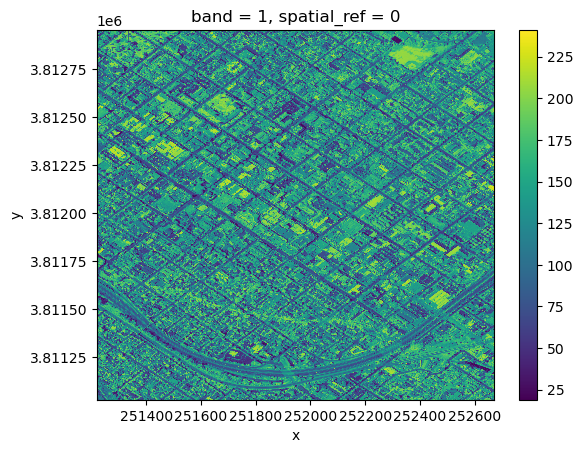

In [6]:
nir.plot()

## RIO Accessor
An accessor in Python let’s us access a different set of properties of an object. In our case, we use the .rio accessor for xarray.DataArrays to access its raster properties. For example, its number of bands, height, width, spatial bounding box, and CRS:


In [7]:
# check geospatial attributes
print('# bands: ', nir.rio.count)
print('height: ', nir.rio.height)
print('width: ', nir.rio.width, '\n')

print('spatial bounding box: ')
print(nir.rio.bounds(), '\n')

print('CRS: ', nir.rio.crs)

# bands:  1
height:  3208
width:  2419 

spatial bounding box: 
(251218.8, 3811027.2, 252670.19999999998, 3812952.0) 

CRS:  EPSG:26911


## Multiband Raster


In [8]:
# open RGB raster
rgb_fp = os.path.join(os.getcwd(),'raster_data','rgb.tif')
rgb = rioxr.open_rasterio(rgb_fp)
rgb

<xarray.DataArray (band: 3, y: 3208, x: 2419)>
[23280456 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1 2 3
  * x            (x) float64 2.512e+05 2.512e+05 ... 2.527e+05 2.527e+05
  * y            (y) float64 3.813e+06 3.813e+06 ... 3.811e+06 3.811e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [9]:
print('rgb shape: ', rgb.shape)
print('rgb # bands: ', rgb.rio.count)

rgb shape:  (3, 3208, 2419)
rgb # bands:  3


In [10]:
# check geospatial attributes
print('shape: ', rgb.shape)
print('data type: ', rgb.dtype)
print('# bands: ', rgb.rio.count)
print('CRS: ', rgb.rio.crs)

# check if the CRSs of the rasters match
print( rgb.rio.crs == nir.rio.crs)

shape:  (3, 3208, 2419)
data type:  uint8
# bands:  3
CRS:  EPSG:26911
True


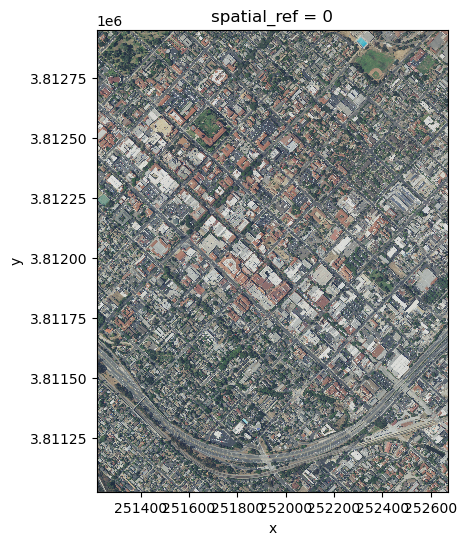

In [11]:
# parameters for plotting rasters
size = 6 # height in in of plot height
aspect = rgb.rio.width / rgb.rio.height # ratio of widht/height

# plot three bands as RGB image
rgb.plot.imshow(size=size, aspect=aspect)

## Box for Clipping

In [12]:
# vertices of our aoi box
points = [[-119.70608227128903, 34.426300194372274],
          [-119.70608227128903, 34.42041139020533],
          [-119.6967885126002, 34.42041139020533],
          [-119.6967885126002, 34.426300194372274],
          [-119.70608227128903, 34.426300194372274]]

In [20]:
# create geodataframe with aoi 
aoi = gpd.GeoDataFrame(geometry=[Polygon(points)],
                           crs='epsg:4326')
aoi

,geometry
0,"POLYGON ((-119.70608 34.42630, -119.70608 34.4..."


<AxesSubplot:>

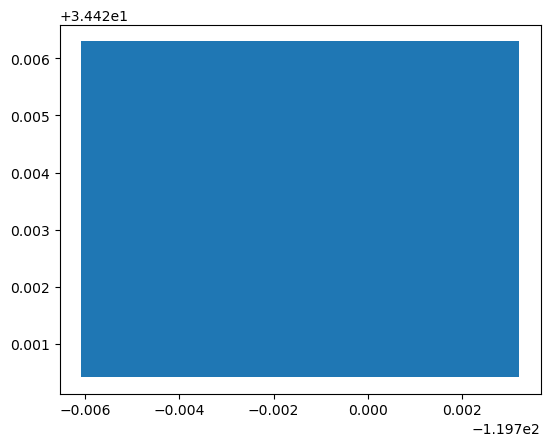

In [21]:
aoi.plot()

Let’s break this down a bit:

- first, we use the shapely’s Polygon() function to create a polygon from our points list.
- in [Polygon(points)] we put this polygon inside a list so we can form the geometry column of our new gpd.GeoDataFrame
- we know all the geoJSON files have CRS equal to EPSG:4326/WGS 84, so we set the the CRS of our new gpd.GeoDataFrame to this.

## Clip Raster
Remember: if two geospatial sets will interact they need to be in the same CRS.
In our case, the aoi gpd.GeoDataFrame does not have the same CRS as the rasters:

In [22]:
# check CRss
print('aoi CRS: ', aoi.crs)
print('nir CRS: ', nir.rio.crs)
print('rgb CRS: ', rgb.rio.crs)

aoi CRS:  epsg:4326
nir CRS:  EPSG:26911
rgb CRS:  EPSG:26911


In [23]:
# reproject aoi to rgb crs
aoi = aoi.to_crs(rgb.rio.crs)
print('matched crs?',  aoi.crs == rgb.rio.crs)
aoi.crs

ProjError: x, y, z, and time must be same size

<AxesSubplot:title={'center':'spatial_ref = 0'}, xlabel='x', ylabel='y'>

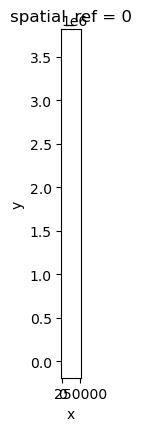

In [17]:
# plot aoi outline and RGB raster together
fig, ax = plt.subplots()
fig.set_size_inches((size, size*aspect)) # reuse size and aspect
rgb.plot.imshow(ax=ax)
aoi.plot(ax=ax, alpha=0.6)

In [18]:
# clip rasters to aoi
rgb_small = rgb.rio.clip_box(*aoi.total_bounds)
nir_small = nir.rio.clip_box(*aoi.total_bounds)

NoDataInBounds: No data found in bounds.

## Compute NDVI
- Normalized Difference Vegetation Index

It's an index used to determine if an area has live green vegetation
calculated using only the red and NIR bands
formula: $$NDVI = (NIR -Red)/(NIR + Red)$$
results range from -1 to 1,
plants: always positive values between 0.2 and 1

In [19]:
#First Select the red band
red = rgb_small.sel(band=1)
red

NameError: name 'rgb_small' is not defined